<a href="https://colab.research.google.com/github/JoshARogers/DATA_340_NLP/blob/main/Natural%20Language%20Processing%20Final/Josh_Rogers_NLP_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports and Functions

In [ ]:
import spacy
NLP = spacy.load("en_core_web_sm")
def extract_noun_adj_phrases(text):
    """Extract noun and adjective phrases from text.

    Args:
        text (str): Text to extract noun and adjective phrases from.

    Returns:
        noun_adj_phrases (list): List of noun and adjective phrases.
    """
    doc = NLP(text)
    noun_adj_phrases = []
    for token in doc:
        if token.pos_ in ["NOUN", "ADJ"]:
            noun_adj_phrases.append(token.text)
    return noun_adj_phrases

In [ ]:
import pandas as pd
tweets = pd.read_csv('/content/drive/MyDrive/archive/ExtractedTweets.csv')

Graph Showing the party split in the dataset

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px
targets = tweets['Party'].groupby(tweets['Party']).count()

# plot the distribution of the target variable
fig = px.bar(targets, x=targets.index, y=targets.values,
             labels={'x':'Party', 'y':'Count'},
             color=targets.index,
             color_discrete_map={'Democrat':'blue', 'Republican':'red'})
fig.show()

## Sentiment of Political Parties

analyze_sentiment function. This is what we use to assign the sentiment to each tweet

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
# Load the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to apply the VADER sentiment analyzer to each tweet in the DataFrame
def analyze_sentiment(tweet):
    # Apply the VADER sentiment analyzer to the tweet and get the sentiment scores
    scores = analyzer.polarity_scores(tweet)
    # Extract the sentiment polarity score from the scores dictionary
    polarity_score = scores['compound']
    # Return 'positive' if sentiment score is greater than 0, 'negative' if sentiment score is less than 0, and 'neutral' otherwise
    if polarity_score > 0:
        return 'positive'
    elif polarity_score < 0:
        return 'negative'
    else:
        return 'neutral'


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Applying the function

In [ ]:
tweets['sentiment'] = tweets['Tweet'].apply(analyze_sentiment)

Graph Showing the Distribution of Sentiment in the Tweets

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px
targets = tweets['sentiment'].groupby(tweets['sentiment']).count()

# plot the distribution of the target variable
fig = px.bar(targets, x=targets.index, y=targets.values,
             labels={'x':'sentiment', 'y':'Count'},
             color=targets.index,
             color_discrete_map={'positive':'green', 'neutral':'yellow', 'negative':'red'})
fig.update_layout(title_text='Distribution of Sentiment in Tweets')
fig.show()

Graph showing the sentiment distribution by party

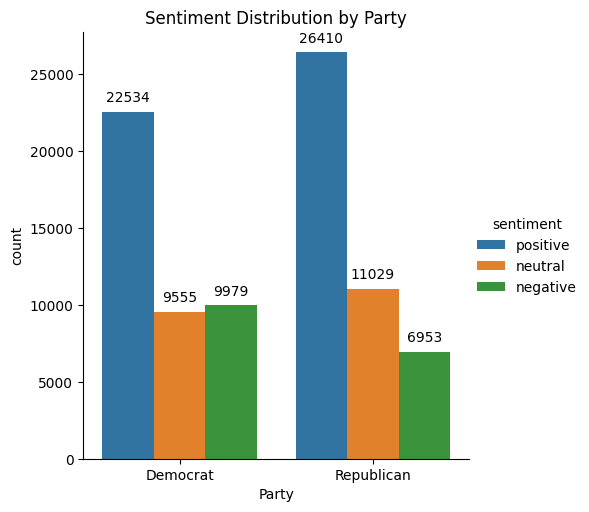

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plot = sns.catplot(x='Party', hue='sentiment', kind='count', data=tweets)

# add count values above each bar
for p in plot.ax.patches:
    plot.ax.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center', xytext = (0, 10),
                     textcoords = 'offset points')

plt.title('Sentiment Distribution by Party')
plt.show()


## Noun & Adjective Logistic Regression

Applying the noun and adjective function set up in imports and functions

In [ ]:
tweets['tokens'] = tweets['Tweet'].apply(extract_noun_adj_phrases)

Spliting the dataset by party

In [ ]:
dems = tweets[tweets['Party'] == 'Democrat']
GOP = tweets[tweets['Party'] == 'Republican']

Democrat TF-IDF

In [ ]:
dems = dems.explode('tokens')
term_frequency = (dems
                  .groupby(by=['tokens'])
                  .agg({'tokens': 'count'})
                  .rename(columns={'tokens': 'term_frequency'})
                  .reset_index()
                  .rename(columns={'tokens': 'term'})
                  .sort_values(by=['term_frequency'], ascending=False)
                 )
term_frequency.head(15)

,term,term_frequency
3,#,4006
30391,today,2151
7483,Today,1591
27168,people,1360
30362,time,1273
29839,students,1233
9028,bill,1182
26217,more,1164
31535,women,1058
12136,families,1019


GOP TF-IDF

In [ ]:
GOP = GOP.explode('tokens')
term_frequency = (GOP
                  .groupby(by=['tokens'])
                  .agg({'tokens': 'count'})
                  .rename(columns={'tokens': 'term_frequency'})
                  .reset_index()
                  .rename(columns={'tokens': 'term'})
                  .sort_values(by=['term_frequency'], ascending=False)
                 )
term_frequency.head(15)

,term,term_frequency
1,#,4056
30196,today,2868
7528,Today,1888
29920,tax,1813
8905,bill,1665
26322,more,1633
12387,great,1495
31047,week,1384
30165,time,1292
26327,morning,1253


Loading in a saved version of the dataset

In [ ]:
import pandas as pd
import numpy as np
tweets = pd.read_csv('/content/drive/MyDrive/tweets_processed.csv')

Last minute cleaning

In [ ]:
tweets[tweets['Party']=='https://t.co/sbSljdw1Zw']
tweets = tweets.drop(42060)
tweets.Party.unique()

array(['Democrat', 'Republican'], dtype=object)

Collecting Sample from the dataset

In [ ]:
tweet_sub = tweets.sample(n=32000)

Using Tfidfvectorizer to convert the text to vectors

In [ ]:
## Let's convert our text to vectors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
tweet_sub.dropna(subset=['tokens'], inplace=True)


vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()
#tweets['tokens'] = [[token.lower() for token in tokens] for tokens in tweets['tokens']]

#X = tfidf_vectorizer.fit_transform([' '.join(tokens) for tokens in tweets['tokens']]).toarray()
X = tfidf_vectorizer.fit_transform(tweet_sub['tokens']).toarray()

y = tweet_sub['Party'].values

train_test_split of X and y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

Fitting the model using logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state = 42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.68


Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

    Democrat       0.68      0.64      0.66      3106
  Republican       0.68      0.71      0.69      3294

    accuracy                           0.68      6400
   macro avg       0.68      0.68      0.68      6400
weighted avg       0.68      0.68      0.68      6400



Confusion Matrix from the model

<Axes: >

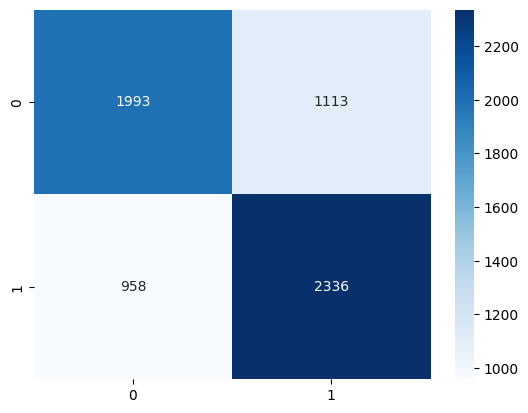

In [ ]:
from sklearn.metrics import confusion_matrix

cfm = confusion_matrix(y_val, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')

## Logistic Regression on Full Dataset

Additional Import Point

In [ ]:
import pandas as pd
tweets = pd.read_csv('/content/drive/MyDrive/archive/ExtractedTweets.csv')

Import Spacy Model + Tokenization

In [ ]:
#Tokenization
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Load the spacy model: nlp
NLP = spacy.load('en_core_web_sm')
tweets['tokens'] = tweets['Tweet'].apply(lambda x: [token.text.lower() for token in NLP(x)])

Lemmatization of Tokens

In [ ]:
### Lemmatize
tweets['lemmas'] = tweets['tokens'].apply(lambda x: [token.lemma_ for token in NLP(" ".join(x))])
tweets

,Party,Handle,Tweet,tokens,lemmas
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P...","[today, ,, senate, dems, vote, to, #, savethei...","[today, ,, senate, dem, vote, to, #, savethein..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...,"[rt, @winterhavensun, :, winter, haven, reside...","[rt, @winterhavensun, :, winter, haven, reside..."
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...,"[rt, @nbclatino, :, .@repdarrensoto, noted, th...","[rt, @nbclatino, :, .@repdarrensoto, note, tha..."
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...,"[rt, @nalcabpolicy, :, meeting, with, @repdarr...","[rt, @nalcabpolicy, :, meet, with, @repdarrens..."
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...,"[rt, @vegalteno, :, hurricane, season, starts,...","[rt, @vegalteno, :, hurricane, season, start, ..."
...,...,...,...,...,...
86455,Republican,RepTomPrice,Check out my op-ed on need for End Executive O...,"[check, out, my, op, -, ed, on, need, for, end...","[check, out, my, op, -, ed, on, need, for, end..."
86456,Republican,RepTomPrice,"Yesterday, Betty &amp; I had a great time lear...","[yesterday, ,, betty, &, amp, ;, i, had, a, gr...","[yesterday, ,, betty, &, amp, ;, I, have, a, g..."
86457,Republican,RepTomPrice,We are forever grateful for the service and sa...,"[we, are, forever, grateful, for, the, service...","[we, be, forever, grateful, for, the, service,..."
86458,Republican,RepTomPrice,Happy first day of school @CobbSchools! #CobbB...,"[happy, first, day, of, school, @cobbschools, ...","[happy, first, day, of, school, @cobbschool, !..."


Stop Word Removal

In [ ]:
tweets['no_stop'] = tweets['lemmas'].apply(lambda x: [token.text for token in NLP(" ".join(x)) if not token.is_stop])


Punctuation Removal

In [ ]:
tweets['no_punc'] = tweets['no_stop'].apply(lambda x: [token.text for token in NLP(" ".join(x)) if not token.is_punct])

Import of preprocessed Dataset

In [ ]:
tweets = pd.read_csv('/content/drive/MyDrive/tweets_clean.csv')

Exploding text for TF-IDF

In [ ]:
tweets = tweets.explode('no_punc')

Splitting tweets by party

In [ ]:
dems = tweets[tweets['Party'] == 'Democrat']
GOP = tweets[tweets['Party'] == 'Republican']

Democrat TF-IDF

In [ ]:
#Democrat TF-IDF
# create a word frequency dataframe
term_frequency = (dems
                  .groupby(by=['no_punc'])
                  .agg({'no_punc': 'count'})
                  .rename(columns={'no_punc': 'term_frequency'})
                  .reset_index()
                  .rename(columns={'no_punc': 'term'})
                  .sort_values(by=['term_frequency'], ascending=False)
                 )
term_frequency.head(20)

,term,term_frequency
63955,rt,9076
12687,amp,4701
67182,today,3848
66892,thank,2687
67592,trump,2489
69536,work,2341
56170,join,1930
69739,year,1829
57551,m,1788
21650,great,1784


GOP TF-IDF

In [ ]:
#Republican TF-IDF
# create a word frequency dataframe
term_frequency = (GOP
                  .groupby(by=['no_punc'])
                  .agg({'no_punc': 'count'})
                  .rename(columns={'no_punc': 'term_frequency'})
                  .reset_index()
                  .rename(columns={'no_punc': 'term'})
                  .sort_values(by=['term_frequency'], ascending=False)
                 )
term_frequency.head(20)

,term,term_frequency
64933,rt,9993
68017,today,4870
12919,amp,4569
67730,thank,3709
21201,great,3012
67454,tax,2575
14219,bill,2377
22250,house,2366
70106,work,2309
15,,2064


Additional Cleaning

In [ ]:
import pandas as pd
tweets = pd.read_csv('/content/drive/MyDrive/tweets_clean.csv')
tweets.dropna(subset=['no_punc'], inplace=True)
tweets = tweets.drop(tweets[tweets['Party'].str.contains('https://t.co/sbSljdw1Zw')].index)

Collecting Sample

In [ ]:
tweet_sub = tweets.sample(n=25000)

Using Tfidfvectorizer to convert the text to vectors

In [ ]:
## Let's convert our text to vectors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()
#tweets['tokens'] = [[token.lower() for token in tokens] for tokens in tweets['tokens']]

#X = tfidf_vectorizer.fit_transform([' '.join(tokens) for tokens in tweets['tokens']]).toarray()
X = tfidf_vectorizer.fit_transform(tweet_sub['no_punc']).toarray()

y = tweet_sub['Party'].values

train_test_split of X and y

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42)

Fitting the modl

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state = 42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.75


Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

    Democrat       0.75      0.71      0.73      3018
  Republican       0.75      0.78      0.76      3232

    accuracy                           0.75      6250
   macro avg       0.75      0.75      0.75      6250
weighted avg       0.75      0.75      0.75      6250



Confusion Matrix of Model

<Axes: >

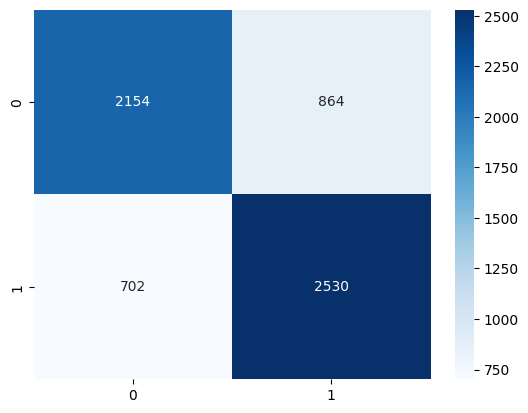

In [ ]:
from sklearn.metrics import confusion_matrix

cfm = confusion_matrix(y_val, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')